In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math as m
import subprocess as sp

def true_solut(t, x):
    a = (t - x) ** 2 - 2 - m.sin(t - x) if x > t else t - x - 2 * m.cos(t - x)
    return 2 * x * m.sin(t) - (x * x - 2) * m.cos(t) + a

def run_cmd(nproc, x_points_num, t_points_num, max_x, max_t, iterations):
    cmd = ['wsl', 'mpirun', '-np', str(nproc), './main',
           str(x_points_num),
           str(t_points_num),
           str(max_x),
           str(max_t),
           str(iterations)
           ]
    output = sp.check_output(cmd, shell=True).decode('cp866')

    if iterations == 0:
        output = [a[:-1].split(' ') for a in (output.split('\n'))[:-1]]
        z = np.array(output, dtype=np.float32)
        x, y = np.meshgrid(np.arange(0, max_x, max_x / x_points_num), np.arange(0, max_t, max_t / t_points_num))
        return x, y, z

    return float(output)

def plot_3d(nproc, x_points_num, t_points_num, max_x, max_t):
    if nproc == 0:
        x, y = np.meshgrid(np.arange(0, max_x, max_x / x_points_num), np.arange(0, max_t, max_t / t_points_num))
        tz = np.array([np.array([true_solut(n, i) for i in x[0]]) for n in np.transpose(y)[0]])
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.set(xlabel='x', ylabel='t', zlabel='u', title='Analytic solution')
        ax.plot_surface(x, y, tz, linewidth=0, antialiased=False, cmap=cm.coolwarm)
    else:
        x, y, z = run_cmd(nproc, x_points_num, t_points_num, max_x, max_t, 0)
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.set(xlabel='x', ylabel='t', zlabel='u', title='Calculated solution nproc = ' + str(nproc))
        ax.plot_surface(x, y, z, linewidth=0, antialiased=False, cmap=cm.coolwarm)


def plot_time_points(initial_points_num, end_points_num, factor, x_points_num, max_x, max_t, iterations):
    def calc_time(nproc):
        x, y = np.array([]), np.array([])
        t_points_num = initial_points_num
        while t_points_num < end_points_num:
            x = np.append(x, t_points_num)
            time = run_cmd(nproc, x_points_num, t_points_num, max_x, max_t, iterations)
            y = np.append(y, time)
            t_points_num *= factor
        return x, y

    fig, ax = plt.subplots()
    ax.grid()
    ax.set(xlabel='points number, n', ylabel='time, s')

    x, ys = calc_time(1)
    ax.plot(x, ys, label='serial')
    ax.legend()

    x, yp2 = calc_time(2)
    ax.plot(x, yp2, label='parallel 2')
    ax.legend()

    x, yp4 = calc_time(4)
    ax.plot(x, yp4, label='parallel 4')
    ax.legend()

    fig, ax = plt.subplots()
    ax.grid()
    ax.set(xlabel='points number, n', ylabel='time, s / n')

    ys = ys / np.array([n for n in x])
    ax.plot(x, ys, label='serial')
    ax.legend()

    yp2 = yp2 / np.array([n for n in x])
    ax.plot(x, yp2, label='parallel 2')
    ax.legend()

    yp4 = yp4 / np.array([n for n in x])
    ax.plot(x, yp4, label='parallel 4')
    ax.legend()

def plot_time_proc(nproc_max, x_points_num, t_points_num, max_x, max_t, iterations):
    fig, ax = plt.subplots()
    ax.grid()
    ax.set(xlabel='processes number', ylabel='time, s', title='Execution time')

    x = range(1, nproc_max + 1)
    y = np.array([])
    for nproc in x:
        time = run_cmd(nproc, x_points_num, t_points_num, max_x, max_t, iterations)
        y = np.append(y, time)

    ax.plot(x, y)

    fig, ax = plt.subplots()
    ax.grid()
    ax.set(xlabel='processes number', ylabel='acceleration', title='Acceleration')
    y = y[0] / y
    ax.plot(x, y)

    fig, ax = plt.subplots()
    ax.grid()
    ax.set(xlabel='processes number', ylabel='efficiency', title='Efficiency')
    y = y / x
    ax.plot(x, y)

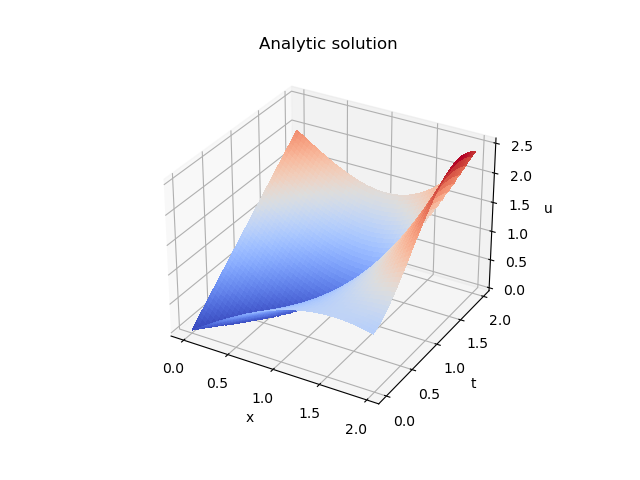

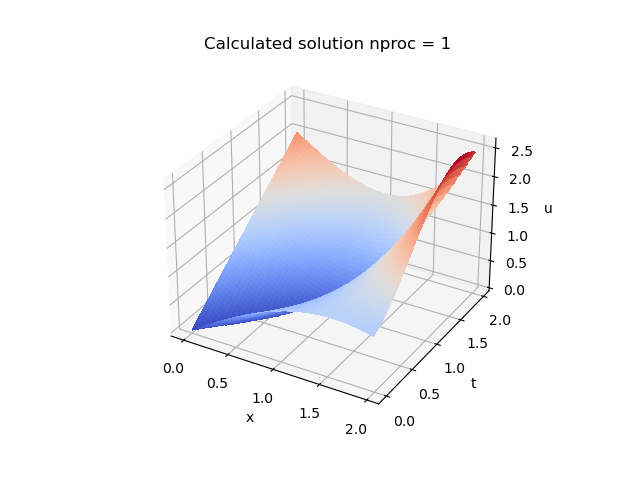

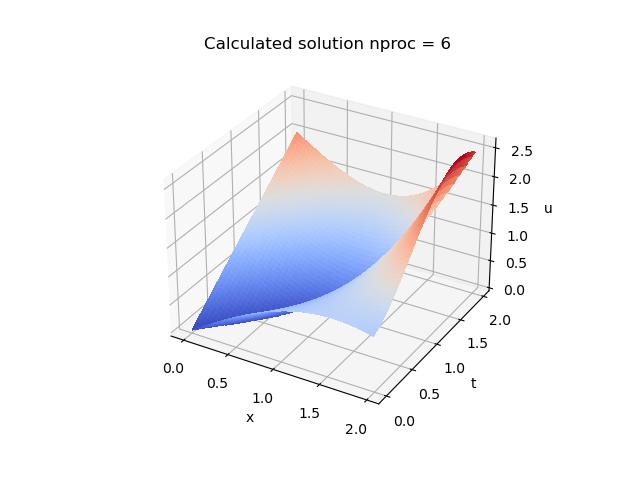

In [7]:
plot_3d(0, 100, 100, 2, 2)
plot_3d(1, 100, 100, 2, 2)
plot_3d(6, 100, 100, 2, 2)

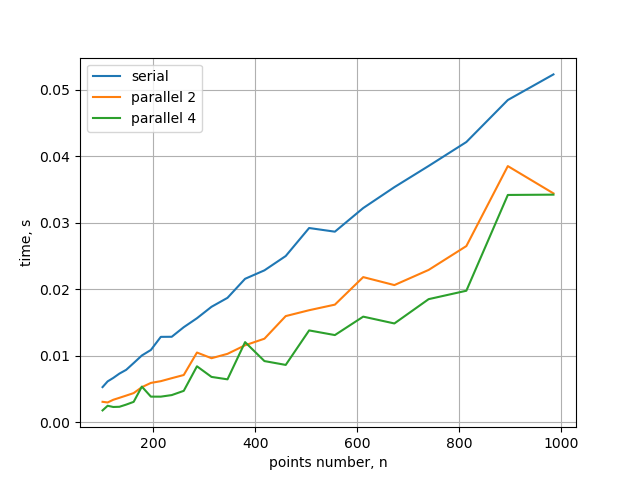

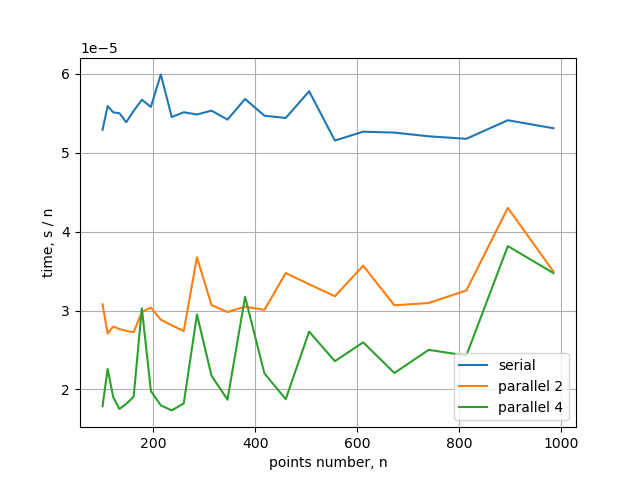

In [9]:
plot_time_points(100, 1000, 1.1, 10000, 2, 2, 10)

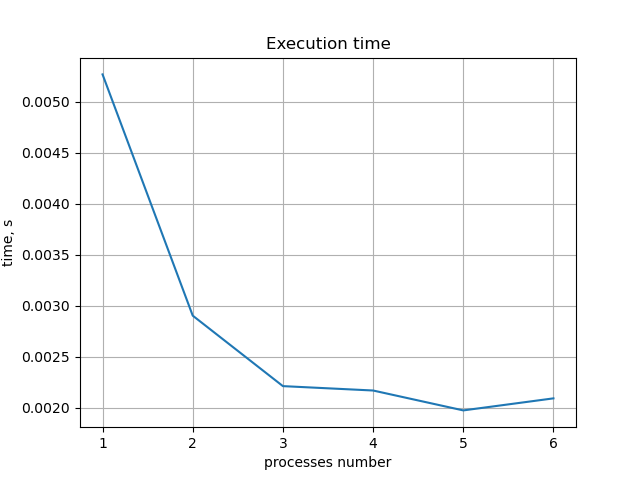

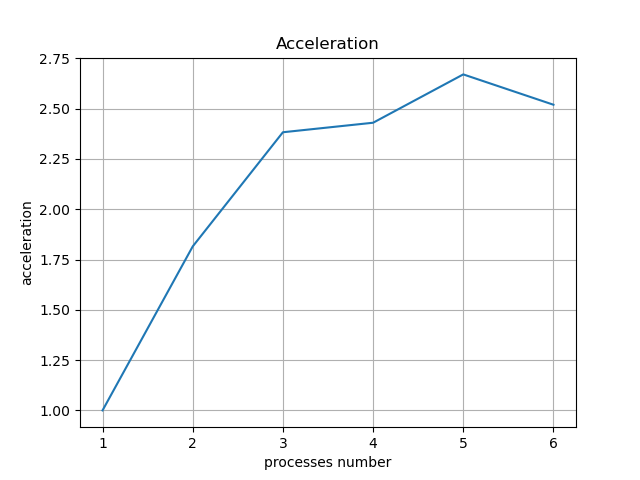

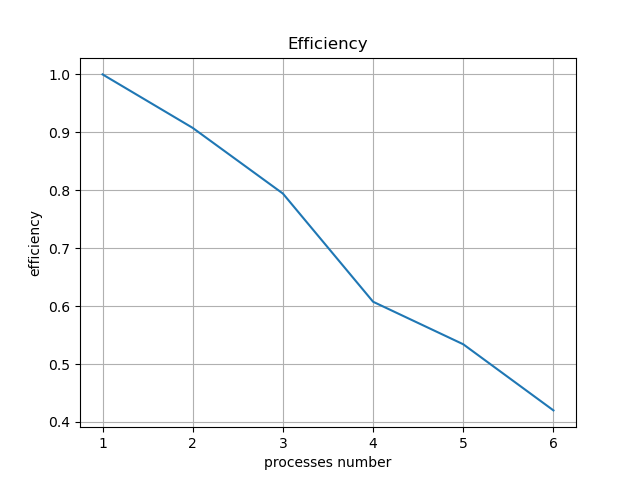

In [8]:
plot_time_proc(6, 10000, 100, 2, 2, 100)